# Predicting of Dielectric Tensors with Euclidean Convolutional Neural Networks & Study on Material Anisotropy

#### This notebook contains the code required to build the network, train, and prediction with equivariant neural network

In [1]:
import math
import time
from typing import Dict, Union
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from tqdm import tqdm
import matplotlib as mpl
import pandas as pd
from e3nn.io import CartesianTensor
from sklearn.model_selection import train_test_split
import e3nn
import plotly.graph_objects as go
from ase.visualize.plot import plot_atoms
from e3nn import o3
from e3nn.io import SphericalTensor
from IPython.display import HTML
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import networkx as nx
from e3nn.math import soft_one_hot_linspace
from e3nn.nn import Gate
from e3nn.nn.models.gate_points_2101 import (Convolution, smooth_cutoff,
                                             tp_path_exists)
from sklearn.metrics import r2_score
from numpy import array
from scipy.stats import gaussian_kde
from torch_cluster import radius_graph
from torch_geometric.data import Data

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
tqdm.pandas(bar_format=bar_format)
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)
palette = ['#2876B2', '#F39957', '#67C7C2', '#C86646']
datasets = ['train', 'valid', 'test']
colors = dict(zip(datasets, palette[:-1]))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])

C:\Users\10450\anaconda3\envs\e3nn3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Pre-training

In [2]:
# util.py contains all necessary functions to train, evaluate and predict with the model
%run util.py

In [5]:
# loading data and filter for dielectric scalar = 15 or less
ct = CartesianTensor("ij=ji")
df,species = load_data('dielectric_data_tensor_born.csv', ct)
df = df[df["dielectric_scalar"] < 15]
df = df.reset_index(drop=True)
species = sorted(list(set(df['species'].sum())))

C:\Users\10450\anaconda3\envs\e3nn3\lib\site-packages\torch\jit\_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "
C:\Users\10450\anaconda3\envs\e3nn3\lib\site-packages\torch\jit\_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [6]:
# one-hot encoding atom type and mass
type_encoding = {}
specie_am = []
for Z in tqdm(range(1, 119), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    specie_am.append(specie.mass)

type_onehot = torch.eye(len(type_encoding))
am_onehot = torch.diag(torch.tensor(specie_am))

100%|██████████| 118/118 [00:00<00:00, 235567.76it/s]                                                                  


In [7]:
# build df.data column to be used during training
r_max = 5.
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, am_onehot, r_max), axis=1)

100%|██████████| 6706/6706 [01:34<00:00, 71.26it/s]                                                                    


split train/dev ...


100%|██████████| 81/81 [00:00<00:00, 104.02it/s]                                                                       


split valid/test ...


100%|██████████| 79/79 [00:00<00:00, 536.95it/s]                                                                       


number of training examples: 5312
number of validation examples: 657
number of testing examples: 737
total number of examples: 6706


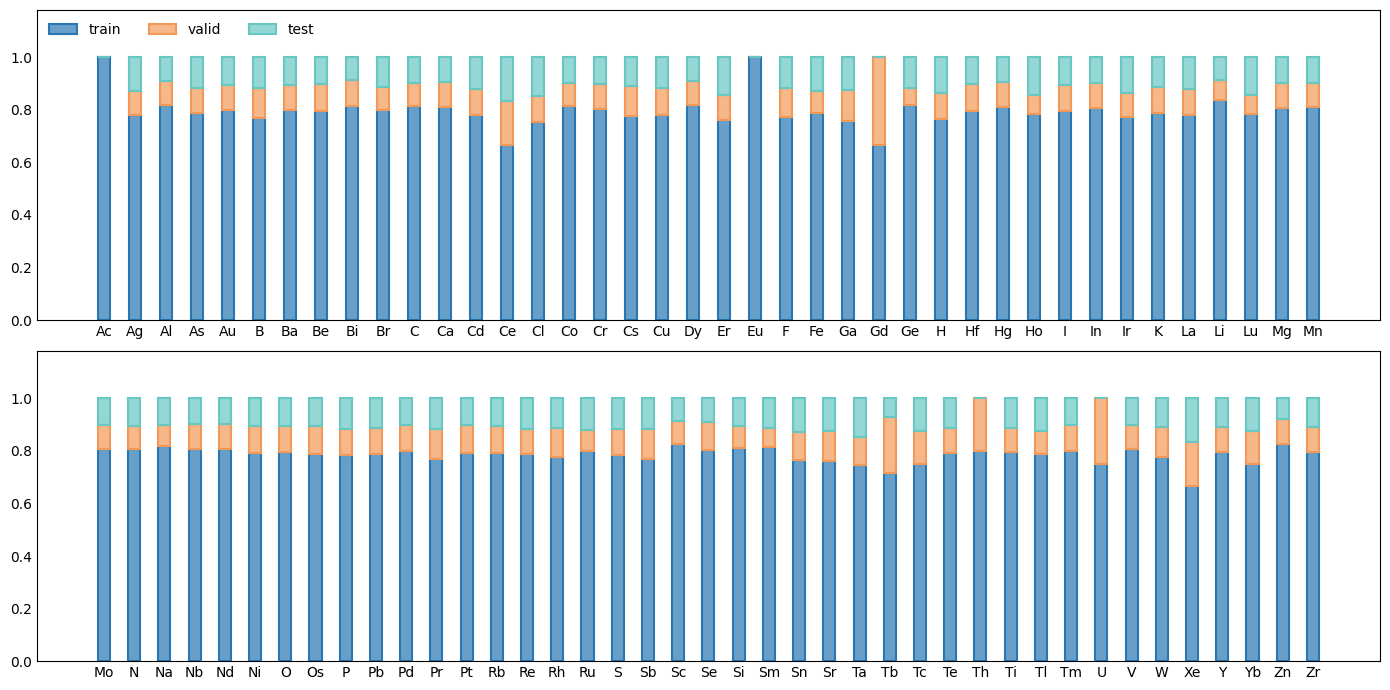

In [8]:
# splitting dataset into train, validation and test
batch_size = 12
idx_train, idx_valid, idx_test = train_valid_test_split(df, species, valid_size=.1, test_size=.1, seed=12, plot=True)
n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)

dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].values, batch_size=batch_size)

In [17]:
# defining custom network class, based on the stock e3nn 'Network' class
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        # embed the mass-weighted one-hot encoding
        self.em = nn.Linear(in_dim, em_dim)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.x = F.relu(self.em(data.x))
        data.z = F.relu(self.em(data.z))
        output = super().forward(data)
        #output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example

        return output

In [18]:
# setting model parameters
out_dim = str(ct)
em_dim = 64
r_max = 5.
lmax = 2

model = PeriodicNetwork(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=out_dim,         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=2,                              # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,                                # multiplicity of irreducible representations
    lmax=lmax,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

# Training

In [19]:
# training
opt = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.98)

loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

device = "cuda:0" if torch.cuda.is_available() else "cpu"

run_name ='model'
model.pool = True

In [ ]:
train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name, max_iter=120, scheduler=scheduler, device=device)

# Prediction

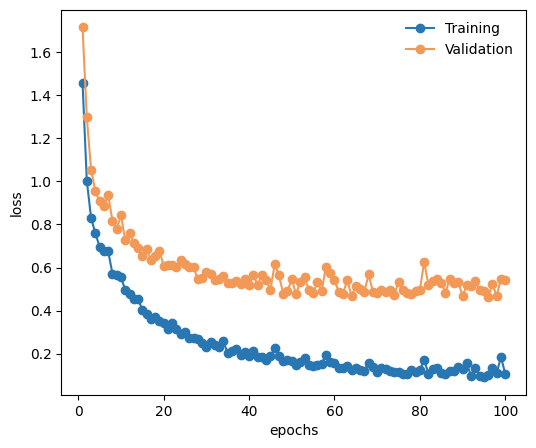

In [20]:
# pre_trained_model.torch includes the loss history and has the parameters of the last epoch.
# best_pre_trained_model.torch is the parameters that resulted in best validation loss during training.
history = torch.load('pre_trained_model.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(steps, loss_train, 'o-', label="Training", color=colors['train'])
ax.plot(steps, loss_valid, 'o-', label="Validation", color=colors['valid'])
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend(frameon=False);

In [21]:
# make predictions for the whole dataset
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load('best_pre_trained_model.torch'))
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=16)
df['mse'] = 0.
df['dielectric_tensor_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.dielectric_irreps, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.dielectric_irreps) - 1, 'dielectric_tensor_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.dielectric_irreps) - 1, 'mse'] = loss
        i0 += len(d.dielectric_irreps)

100%|██████████| 420/420 [00:22<00:00, 18.31it/s]                                                                      


In [28]:
# converting irreps into 3x3 tensors and create new columns.
df["dielectric_tensor_pred_cart"] = ct.to_cartesian((torch.tensor(df["dielectric_tensor_pred"].values.tolist())).squeeze()).tolist()
df["dielectric_scalar_pred"] = [np.linalg.eigvalsh(x).mean() for x in df["dielectric_tensor_pred_cart"]]
df["dielectric_ar_pred"] = [np.linalg.eigvalsh(x).max()/np.linalg.eigvalsh(x).min() for x in df["dielectric_tensor_pred_cart"]]
df["dielectric_ar"] = [np.linalg.eigvalsh(eval(x)).max()/np.linalg.eigvalsh(eval(x)).min() for x in df["dielectric_tensor"]]
df["dielectric_ar_difference"] = df["dielectric_ar"] - df["dielectric_ar_pred"]

df["dielectric_tensor_pred_cart_adjusted"] = df["dielectric_tensor_pred_cart"].apply(lambda x: np.array(x, copy=True))
for i in range(len(df)):
    for x in range(3):
        if df["dielectric_tensor_pred_cart_adjusted"].loc[i][x][x] < 1.:
            df["dielectric_tensor_pred_cart_adjusted"].loc[i][x][x] = 1.
            
df["dielectric_scalar_pred_adjusted"] = [np.linalg.eigvalsh(x).mean() for x in df["dielectric_tensor_pred_cart_adjusted"]]            
df["dielectric_ar_pred_adjusted"] = [np.linalg.eigvalsh(x).max()/np.linalg.eigvalsh(x).min() for x in df["dielectric_tensor_pred_cart_adjusted"]]
df["dielectric_ar_difference_adjusted"] = df["dielectric_ar"] - df["dielectric_ar_pred_adjusted"]
df.rename(columns={'dielectric_irreps': 'dielectric_tensor_irreps'}, inplace=True)

C:\Users\10450\anaconda3\envs\e3nn3\lib\site-packages\torch\jit\_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


# Evaluation

### plotting adjusted dielectric scalars and anisotropy ratio

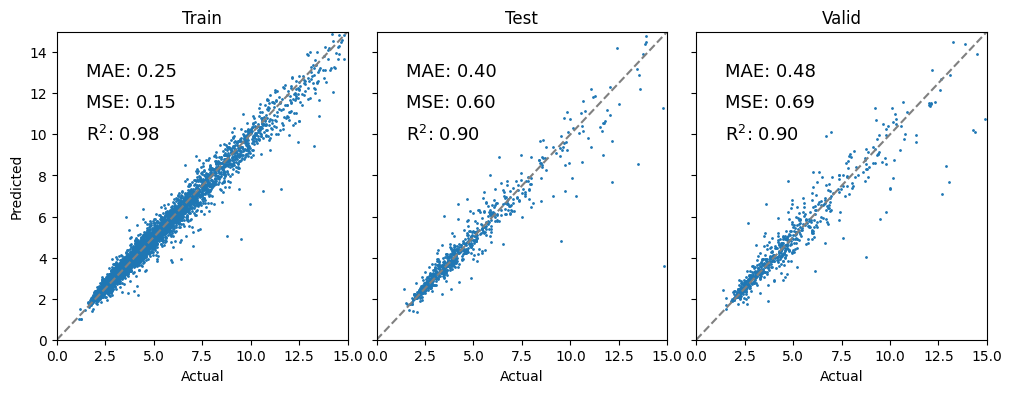

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
ax1.set(ylabel="Predicted", title="Train")
ax2.set(title="Test")
ax3.set(title="Valid")
plot_adjusted(df.iloc[idx_train], ax1, "dielectric_scalar", "dielectric_scalar_pred_adjusted")
plot_adjusted(df.iloc[idx_test], ax2, "dielectric_scalar", "dielectric_scalar_pred_adjusted")
plot_adjusted(df.iloc[idx_valid], ax3, "dielectric_scalar", "dielectric_scalar_pred_adjusted")
plt.subplots_adjust(wspace=0.1)

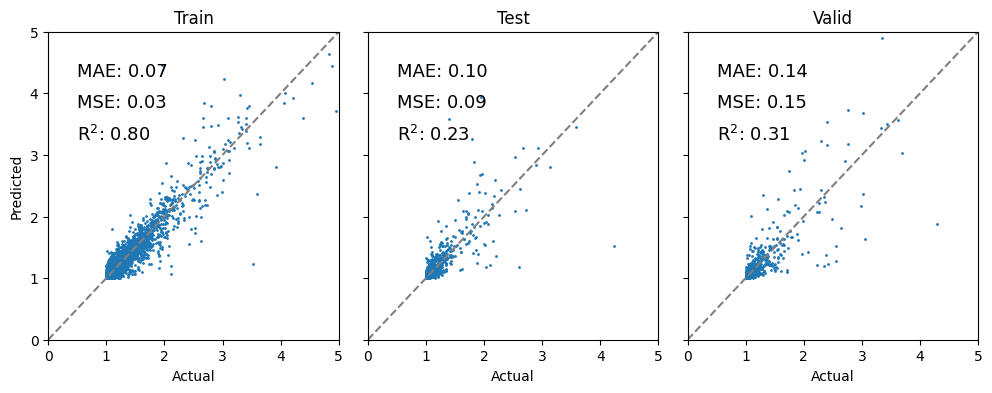

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
ax1.set(ylabel="Predicted", title="Train")
ax2.set(title="Test")
ax3.set(title="Valid")
plot_adjusted(df.iloc[idx_train], ax1, "dielectric_ar", "dielectric_ar_pred_adjusted", xmax=5)
plot_adjusted(df.iloc[idx_test], ax2, "dielectric_ar", "dielectric_ar_pred_adjusted", xmax=5)
plot_adjusted(df.iloc[idx_valid], ax3, "dielectric_ar", "dielectric_ar_pred_adjusted", xmax=5)
plt.subplots_adjust(wspace=0.1)

In [31]:
# define a function to investigate individual materials
def print_info(y, df):
    if y in idx_train:
        print("Training Set")
    if y in idx_valid:
        print("Validation Set")
    if y in idx_test:
        print("Test Set")
        
    print("Entry: ", y)
    print(df["structure"].loc[y])
    print("-------------------\n")
    print("Dielectric")
    print("  Actual\n")
    print(np.array(eval(df["dielectric_tensor"].loc[y])).round(4))
    print("Actual irreps: ")
    print(np.array(df['dielectric_tensor_irreps'].loc[y]).round(4))
    print("\n")

    print("  Predicted\n")
    print(np.array(df["dielectric_tensor_pred_cart"].loc[y], dtype=float).round(4))
    print("Pred irreps: ")
    print(np.array(df['dielectric_tensor_pred'].loc[y]).round(4))

    print("\nAnistropy")
    print("  Actual:", df["dielectric_ar"].loc[y])
    print("  Pred:", df["dielectric_ar_pred"].loc[y])
    print("  Adjusted:", df["dielectric_ar_pred_adjusted"].loc[y])
    print("\nCell Parameter")
    print(df.loc[y]["structure"].cell.array)
    print("-------------------\n")
    
    return

In [32]:
print_info(555, df)

Training Set
Entry:  555
Atoms(symbols='B2As2', pbc=True, cell=[[1.695466, -2.936634, 0.0], [1.695466, 2.936634, 0.0], [0.0, 0.0, 5.609546]])
-------------------

Dielectric
  Actual

[[ 9.6501  0.      0.    ]
 [ 0.      9.6501  0.    ]
 [ 0.      0.     10.1008]]
Actual irreps: 
[16.9747  0.      0.     -0.184   0.      0.3187]


  Predicted

[[ 9.5196  0.      0.    ]
 [ 0.      9.5196 -0.    ]
 [ 0.     -0.      9.5938]]
Pred irreps: 
[[16.5313  0.      0.     -0.0303 -0.      0.0524]]

Anistropy
  Actual: 1.0467018994621817
  Pred: 1.0077887409304487
  Adjusted: 1.0077887409304487

Cell Parameter
[[ 1.695466 -2.936634  0.      ]
 [ 1.695466  2.936634  0.      ]
 [ 0.        0.        5.609546]]
-------------------

